<a href="https://colab.research.google.com/github/samarkinav/Kaggle/blob/main/%D0%A0%D0%BE%D1%81%D0%9D%D0%B5%D1%84%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.feature_selection import SelectKBest, f_regression

import lightgbm as lgb

# Чтение данных

In [2]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
#well_works_df = pd.read_csv('well_works.csv')

In [3]:
train_df.tail()

,Dnytr,H_din,Q_OIS,NomMoschn,Hperf,NomNapor,Water_cut,NomPodacha,Dnkt,H_sp,P_plst,Hvd,Extend_Hvd,PlNeft,VyazkNeft,SumTolshin,P_zatr,PlVody,Pnas,Inject_0,Inject_1,Inject_2,Inject_3,BHP,State,IDN_type,NalichSep,Formation_lbl,state_age,Date,Start_date,Well_ID,id,VNR
2782436,130.6,2120.0,32.0,58.0,17.0,2378.0,7.0,60.0,73.0,2480.0,163.00000,2581.0,103.4585,0.855000,1.34000,11.0,16.0,1.003000,116.00,NaN,171.741935,425.032258,NaN,47.76,1,0,0.0,35,1.0,1980-01-04,1979-12-25,7984,55726,1
2782437,129.0,2500.0,30.0,40.0,51.0,2190.0,9.0,50.0,73.0,2652.0,252.04928,2826.0,158.0900,0.869875,1.50125,29.0,22.0,1.008138,114.75,67.322581,110.419355,199.354839,125.129032,46.13,1,0,1.0,"3,5",625.0,1980-01-04,1979-12-28,6200,42565,1
2782438,130.6,2269.0,64.0,50.0,22.0,2393.0,5.0,50.0,73.0,2791.0,234.00000,2923.0,446.0205,0.855000,1.34000,11.4,12.9,1.003000,116.00,474.290323,229.806452,284.935484,48.129032,52.68,1,0,0.0,35,71.0,1980-01-04,1979-12-24,7465,52512,1
2782439,130.6,NaN,396.0,180.0,13.0,2000.0,95.0,200.0,73.0,2260.0,207.00000,2524.0,80.0000,0.873000,3.08000,10.4,NaN,1.010000,77.90,997.612903,674.064516,NaN,NaN,71.08,1,1,1.0,23,19.0,1980-01-04,1979-12-26,806,4545,1
2782440,129.0,1576.0,430.0,300.0,22.0,1762.0,97.0,500.0,73.0,2005.0,194.80000,2170.0,152.5000,0.877000,3.97650,29.4,0.1,1.008000,68.31,1210.096774,NaN,67.258065,594.225806,44.74,1,0,0.0,"7,8",673.0,1980-01-04,1979-12-20,3323,22188,1


В таблицах test и train признаки:

- Dnytr - ?
- H_din - динамический уровень
- Q_OIS - дебит жидкости (целевая переменная)
- NomMoschn - номинальная мощность
- Hperf - глубина перфораций
- NomNapor - номинальный напор
- Water_cut - обводненность
- NomPodacha - номинальная подача
- Dnkt - диаметр НКТ
- H_sp - глубина спуска
- P_plst - пластовое давление
- Hvd - глубина верхних дыр перфораций
- Extend_Hvd - удлинение верхних дыр перфораций
- PlNeft - плотность нефти
- VyazkNeft - вязкость нефти
- SumTolshin - сумма нефтенасыщенных толщин
- P_zatr - затрубное давление
- PlVody - плотность воды
- Pnas - давление насыщения
- Inject_0, Inject_1, Inject_2, Inject_3 - приемистость ближайших нагнетательных скважин
- BHP - забойное давление 
- State - ?
- IDN_type - тип ГТМ (категориальный признак) 
- NalichSep - наличие сепаратора (бинарный признак)
- Formation_lbl - метка пласта (категориальный признак)
- state_age - ?
- Date - дата измерения значений вещественных признаков (таких, как Q_OIS и BHP)
- Start_date - дата начала события ГТМ
- Well_ID - идентификатор скважины
- id - идентификатору события ИДН (интенсификация добычи нефти)  
- VNR - выход скважины на режим (бинарный признак)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782441 entries, 0 to 2782440
Data columns (total 34 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Dnytr          float64
 1   H_din          float64
 2   Q_OIS          float64
 3   NomMoschn      float64
 4   Hperf          float64
 5   NomNapor       float64
 6   Water_cut      float64
 7   NomPodacha     float64
 8   Dnkt           float64
 9   H_sp           float64
 10  P_plst         float64
 11  Hvd            float64
 12  Extend_Hvd     float64
 13  PlNeft         float64
 14  VyazkNeft      float64
 15  SumTolshin     float64
 16  P_zatr         float64
 17  PlVody         float64
 18  Pnas           float64
 19  Inject_0       float64
 20  Inject_1       float64
 21  Inject_2       float64
 22  Inject_3       float64
 23  BHP            float64
 24  State          int64  
 25  IDN_type       int64  
 26  NalichSep      float64
 27  Formation_lbl  object 
 28  state_age      float64
 29  Date          

### Признаки даты:

In [5]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Start_date'] = pd.to_datetime(train_df['Start_date'])

test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Start_date'] = pd.to_datetime(test_df['Start_date'])

#well_works_df['Date_VNR'] = pd.to_datetime(well_works_df['Date_VNR'])
#well_works_df['Start_date'] = pd.to_datetime(well_works_df['Start_date'])

### Категориальные признаки:

В описании датасета заявлено 2 категориальных признака, рассмотрим их поподробнее:

In [6]:
print("Кол-во уникальных значений категориального признака 'IDN_type' в таблице train_df - {}"\
      .format(train_df.IDN_type.nunique()))
print("Кол-во уникальных значений категориального признака 'IDN_type' в таблице test_df - {}"\
      .format(test_df.IDN_type.nunique()))

Кол-во уникальных значений категориального признака 'IDN_type' в таблице train_df - 2
Кол-во уникальных значений категориального признака 'IDN_type' в таблице test_df - 2


In [7]:
print("Кол-во уникальных значений категориального признака 'Formation_lbl' в таблице train_df - {}"\
      .format(train_df.Formation_lbl.nunique()))
print("Кол-во уникальных значений категориального признака 'Formation_lbl' в таблице test_df - {}"\
      .format(test_df.Formation_lbl.nunique()))

Кол-во уникальных значений категориального признака 'Formation_lbl' в таблице train_df - 88
Кол-во уникальных значений категориального признака 'Formation_lbl' в таблице test_df - 89


Признак 'IDN_type' бинарный, имеет тип int.  
Признак 'Formation_lbl' переведем в тип category: 

In [8]:
train_df['Formation_lbl'] = train_df['Formation_lbl'].astype('category')

test_df['Formation_lbl'] = test_df['Formation_lbl'].astype('category')

# Анализ задачи

Отфильтруем записи по одному из id, чтобы понять, какие данные менялись с течением времени и какие признаки нас потенциально интересуют для обучения нашей модели.

In [9]:
df = train_df[(train_df.id==55726.0)&(train_df.VNR!=1)]
df

,Dnytr,H_din,Q_OIS,NomMoschn,Hperf,NomNapor,Water_cut,NomPodacha,Dnkt,H_sp,P_plst,Hvd,Extend_Hvd,PlNeft,VyazkNeft,SumTolshin,P_zatr,PlVody,Pnas,Inject_0,Inject_1,Inject_2,Inject_3,BHP,State,IDN_type,NalichSep,Formation_lbl,state_age,Date,Start_date,Well_ID,id,VNR
2672983,130.6,NaN,42.0,58.0,17.0,2378.0,14.0,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,231.866667,NaN,NaN,NaN,1,0,0.0,35,1.0,1979-07-05,1979-12-25,7984,55726,0
2673769,130.6,2048.0,NaN,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,17.5,1.003,116.0,NaN,231.866667,NaN,NaN,54.09,1,0,0.0,35,1.0,1979-07-06,1979-12-25,7984,55726,0
2675301,130.6,NaN,NaN,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,231.866667,NaN,NaN,NaN,1,0,0.0,35,1.0,1979-07-07,1979-12-25,7984,55726,0
2676542,130.6,NaN,NaN,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,231.866667,NaN,NaN,NaN,1,0,0.0,35,1.0,1979-07-08,1979-12-25,7984,55726,0
2677999,130.6,2048.0,41.0,58.0,17.0,2378.0,14.0,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,17.5,1.003,116.0,NaN,231.866667,NaN,NaN,54.19,1,0,0.0,35,1.0,1979-07-09,1979-12-25,7984,55726,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2782323,130.6,NaN,0.0,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,171.741935,425.032258,NaN,NaN,0,0,0.0,35,1.0,1979-12-30,1979-12-25,7984,55726,0
2782375,130.6,NaN,0.0,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,171.741935,425.032258,NaN,NaN,0,0,0.0,35,1.0,1979-12-31,1979-12-25,7984,55726,0
2782391,130.6,NaN,0.0,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,171.741935,425.032258,NaN,NaN,0,0,0.0,35,1.0,1980-01-01,1979-12-25,7984,55726,0
2782422,130.6,NaN,0.0,58.0,17.0,2378.0,NaN,60.0,73.0,2480.0,163.0,2581.0,103.4585,0.855,1.34,11.0,NaN,1.003,116.0,NaN,171.741935,425.032258,NaN,NaN,0,0,0.0,35,1.0,1980-01-02,1979-12-25,7984,55726,0


In [10]:
df.nunique()

Dnytr              1
H_din             10
Q_OIS             13
NomMoschn          1
Hperf              1
NomNapor           1
Water_cut          7
NomPodacha         1
Dnkt               1
H_sp               1
P_plst             2
Hvd                1
Extend_Hvd         1
PlNeft             1
VyazkNeft          1
SumTolshin         1
P_zatr             8
PlVody             1
Pnas               1
Inject_0           0
Inject_1           7
Inject_2           3
Inject_3           0
BHP               43
State              2
IDN_type           1
NalichSep          1
Formation_lbl      1
state_age          1
Date             183
Start_date         1
Well_ID            1
id                 1
VNR                1
dtype: int64

Большинство признаков не меняются с течением времени. Хотим учитывать историю изменения целевого признака при построении модели. Но как это сделать? Это не временной ряд, поскольку данные предоставлены не за равные промежутки времени, и зачастую вообще пропущены.

# Baseline model

Давайте в качестве baseline модели построим модель, использующую для обучения и прогнозирования значения признаков только предыдущего дня перед выходом на режим.

In [11]:
def prepare_data_for_baseline_model(data):
    base = data.sort_values(['Date']).groupby(['id']).apply(lambda x: x.iloc[-2])
    base.drop(columns=['id'], axis=1, inplace=True)

    target = data.sort_values(['Date']).groupby(['id'])['Q_OIS', 'Well_ID', 'id']\
                        .apply(lambda x: x.iloc[-1])
    target.drop(columns=['id'], axis=1, inplace=True)

    base = base.merge(target, on=['Well_ID', 'id'])
    base.drop(columns=['Q_OIS_x'], axis=1, inplace=True)
    
    base.rename(columns={'Q_OIS_y':'target'}, inplace=True)
    
    return base

In [12]:
base_train = prepare_data_for_baseline_model(train_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


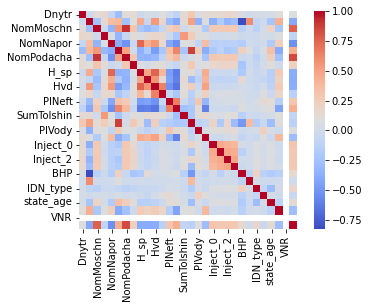

In [13]:
corr_mat = base_train.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

In [14]:
corr_mat.where(np.triu(corr_mat > 0.7, k=1)).stack().sort_values(ascending=False)

NomMoschn   NomPodacha    0.912970
Water_cut   P_zatr        0.872364
NomPodacha  target        0.849193
NomMoschn   target        0.766628
H_sp        Hvd           0.762993
NomNapor    H_sp          0.745898
dtype: float64

In [15]:
base_train.describe()

,Dnytr,H_din,NomMoschn,Hperf,NomNapor,Water_cut,NomPodacha,Dnkt,H_sp,P_plst,Hvd,Extend_Hvd,PlNeft,VyazkNeft,SumTolshin,P_zatr,PlVody,Pnas,Inject_0,Inject_1,Inject_2,Inject_3,BHP,State,IDN_type,NalichSep,state_age,Well_ID,VNR,target
count,15208.000000,29.000000,14914.000000,15037.000000,15142.000000,96.000000,15153.000000,15184.000000,15540.000000,15207.000000,15208.000000,15208.000000,15208.000000,15012.000000,14884.000000,29.000000,15208.000000,15208.000000,9276.000000,9225.000000,9429.000000,8913.000000,425.000000,15622.000000,15622.000000,15208.000000,15622.000000,15622.000000,15622.0,15622.000000
mean,131.316895,1667.758621,100.900054,34.218042,2102.328358,51.297917,180.605906,71.626981,2399.835423,233.716452,2673.573544,203.353428,0.865895,2.155230,20.061399,19.317241,1.009188,97.494524,346.082105,347.247198,359.650424,365.947250,107.964175,0.005953,0.457112,0.507365,384.890091,4047.189412,0.0,195.350718
std,8.379050,672.695944,66.956281,38.168548,306.062872,35.500935,157.611572,4.251407,338.015067,37.232678,287.943903,162.933007,0.011336,1.088879,20.454091,9.144283,0.004784,15.222296,254.670982,258.569859,267.067546,259.355683,39.735559,0.076929,0.498173,0.499962,352.543323,2406.997541,0.0,174.948769
min,89.000000,360.000000,11.000000,0.600000,450.000000,0.000000,6.000000,1.000000,500.000000,100.000000,1917.600000,0.000000,0.810000,0.300000,0.100000,0.000000,0.969077,41.000000,1.419355,1.068966,0.000000,0.935484,25.580000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,1.000000
25%,127.000000,1165.000000,50.000000,12.100000,1916.000000,16.000000,60.000000,73.000000,2203.000000,208.000000,2489.000000,80.695000,0.855000,1.340000,9.000000,13.700000,1.005000,90.000000,161.451613,157.774194,168.193548,175.200000,81.320000,0.000000,0.000000,0.000000,123.000000,2029.000000,0.0,64.000000
50%,129.000000,1638.000000,72.000000,23.600000,2161.000000,46.650000,125.000000,73.000000,2420.000000,237.000000,2653.600000,163.830000,0.869830,1.607200,14.800000,18.400000,1.010000,97.000000,290.262366,288.733333,298.064516,308.166667,105.370000,0.000000,0.000000,1.000000,274.000000,3935.500000,0.0,132.000000
75%,130.600000,2342.000000,134.200000,44.000000,2314.000000,89.250000,250.000000,73.000000,2640.000000,262.000000,2869.000000,285.525000,0.873000,2.940000,26.400000,26.500000,1.012000,108.100000,475.327462,480.000000,492.225806,506.677419,129.510000,0.000000,1.000000,1.000000,541.000000,5737.000000,0.0,270.000000
max,223.000000,2632.000000,660.000000,553.000000,3155.000000,99.000000,1325.000000,114.000000,3481.000000,385.000000,3856.000000,1188.091180,0.898000,7.140000,529.200000,37.700000,1.020000,168.000000,3118.055556,4469.333333,3485.366667,2178.166667,243.330000,1.000000,1.000000,1.000000,3125.000000,8693.000000,0.0,1630.000000


In [16]:
for col in base_train.columns:
    pct_missing = np.mean(base_train[col].isnull())
    if pct_missing > 0:
        print('{} - {}%'.format(col, round(pct_missing*100, 2)))

Dnytr - 2.65%
H_din - 99.81%
NomMoschn - 4.53%
Hperf - 3.74%
NomNapor - 3.07%
Water_cut - 99.39%
NomPodacha - 3.0%
Dnkt - 2.8%
H_sp - 0.52%
P_plst - 2.66%
Hvd - 2.65%
Extend_Hvd - 2.65%
PlNeft - 2.65%
VyazkNeft - 3.9%
SumTolshin - 4.72%
P_zatr - 99.81%
PlVody - 2.65%
Pnas - 2.65%
Inject_0 - 40.62%
Inject_1 - 40.95%
Inject_2 - 39.64%
Inject_3 - 42.95%
BHP - 97.28%
NalichSep - 2.65%


Удалим из рассмотрения признаки с более 90% пропущенных данных, так как они не являются информативными.  
  
Признаки с менее 5% пропущенных значений - заполним медианами.  
  
К признакам 'Inject_0', 'Inject_1', 'Inject_2', 'Inject_3' есть вопросы. Заполним их тоже медианами...  
  
Так же нас не будут интересовать признаки даты.

In [18]:
y = base_train.target
base_train.drop(columns=['H_din', 'Water_cut', 'P_zatr', 'BHP', 'Date', 'Start_date', 'target', 'VNR'], inplace=True)

In [19]:
base_train.fillna(base_train.median(axis = 0), axis=0 , inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [20]:
base_train.isna().sum()

Dnytr            0
NomMoschn        0
Hperf            0
NomNapor         0
NomPodacha       0
Dnkt             0
H_sp             0
P_plst           0
Hvd              0
Extend_Hvd       0
PlNeft           0
VyazkNeft        0
SumTolshin       0
PlVody           0
Pnas             0
Inject_0         0
Inject_1         0
Inject_2         0
Inject_3         0
State            0
IDN_type         0
NalichSep        0
Formation_lbl    0
state_age        0
Well_ID          0
dtype: int64

In [21]:
base_train['Formation_lbl'] = base_train['Formation_lbl'].astype('category')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(base_train, y, test_size=0.3, random_state=30)
print(X_train.shape[0], X_test.shape[0])

10935 4687


Воспользуемся кросс-валидаций для подроба количества деревьев. В качестве метрики оценки модели будем использовать среднюю абсолютную ошибку в % - mean absolute percentage error.

In [23]:
def lgbm_cv(X_train, y_train, X_test, y_test):
  lg = lgb.LGBMRegressor(silent=False)
  parametrs = {"n_estimators": range(10,200,10)}
  grid_search_cv = GridSearchCV(lg, n_jobs=-1, param_grid=parametrs, cv=10, scoring='neg_mean_absolute_percentage_error')
  grid_search_cv.fit(X_train, y_train)
  best_n_estimators = grid_search_cv.best_estimator_.n_estimators

  train_data = lgb.Dataset(X_train, label=y_train)
  validation_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
  param = {'objective':'regression_l1', 'learning_rate':0.06, 'lambda_l1':0.1}
  categ_features_name = ['Formation_lbl']
  bst = lgb.train(param, train_data, best_n_estimators, valid_sets=[validation_data], categorical_feature = categ_features_name)
  
  y_train_predict_lgbm = bst.predict(X_train)
  y_test_predict_lgbm = bst.predict(X_test)

  print('Количество деревьев: {}'.format(best_n_estimators))
  print('MAPE на тренировочной выборке: {}'.format(mape(y_train,y_train_predict_lgbm)))
  print('MAPE на тестовой выборке: {}'.format(mape(y_test,y_test_predict_lgbm)))


In [24]:
lgbm_cv(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Formation_lbl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 118.702
[2]	valid_0's l1: 113.113
[3]	valid_0's l1: 108.019
[4]	valid_0's l1: 103.235
[5]	valid_0's l1: 98.693
[6]	valid_0's l1: 94.4433
[7]	valid_0's l1: 90.5439
[8]	valid_0's l1: 86.9218
[9]	valid_0's l1: 83.6019
[10]	valid_0's l1: 80.5567
[11]	valid_0's l1: 77.6938
[12]	valid_0's l1: 74.8535
[13]	valid_0's l1: 72.2614
[14]	valid_0's l1: 69.9993
[15]	valid_0's l1: 67.8412
[16]	valid_0's l1: 65.7971
[17]	valid_0's l1: 63.8377
[18]	valid_0's l1: 62.0825
[19]	valid_0's l1: 60.3841
[20]	valid_0's l1: 58.8675
[21]	valid_0's l1: 57.4746
[22]	valid_0's l1: 56.1923
[23]	valid_0's l1: 55.0335
[24]	valid_0's l1: 53.8681
[25]	valid_0's l1: 52.846
[26]	valid_0's l1: 51.8214
[27]	valid_0's l1: 50.9055
[28]	valid_0's l1: 50.0599
[29]	valid_0's l1: 49.3008
[30]	valid_0's l1: 48.5675
[31]	valid_0's l1: 47.8837
[32]	valid_0's l1: 47.2976
[33]	valid_0's l1: 46.7711
[34]	valid_0's l1: 46.2532
[35]	valid_0's l1: 45.81
[36]	valid_0's l1: 45.3918
[37]	valid_0's l1: 45.0363
[38]	valid_0's

# Генерация новых признаков

Попробуем облачить историю целевой переменной в новые признаки. Проанализируем за какое время мы имеем информацию по каждому id.

In [25]:
info = train_df.sort_values(['Date']).groupby(['id'])['Date'].apply(lambda x: x.iloc[-1]-x.iloc[0])
info.mean()

Timedelta('179 days 01:07:39.505825118')

В среднем по каждому id есть информация за 179 дней (около полугода). Можно создать признаки - медиана целевой переменной за последние 6 месяцев.

In [26]:
def generate_new_features(data):
  data = data[data.VNR!=1]['Q_OIS']
  res = []
  i = 6
  temp = np.array_split(data, i)
  for j in range(i):
    res.append(round(temp[j].median(), 2))
  return res

In [27]:
new = pd.DataFrame(columns=['Q_OIS_30','Q_OIS_60','Q_OIS_90','Q_OIS_120','Q_OIS_150','Q_OIS_180'])
for j in train_df.id.unique():
  new.at[j, :] = generate_new_features(train_df[train_df.id==j])

In [28]:
new.head()

,Q_OIS_30,Q_OIS_60,Q_OIS_90,Q_OIS_120,Q_OIS_150,Q_OIS_180
30413,0.0,0.0,0.0,3.02,0.0,0.0
26087,0.0,0.0,7.0,14.0,NaN,0.0
58863,0.0,22.5,80.0,100.0,100.0,0.0
56313,0.0,112.5,120.0,126.0,0.0,0.0
27819,NaN,56.0,57.6,54.5,56.75,0.0


In [29]:
new.isna().sum()

Q_OIS_30     105
Q_OIS_60      63
Q_OIS_90      52
Q_OIS_120     50
Q_OIS_150     47
Q_OIS_180      1
dtype: int64

Заполним пропущенные значения медианой по строке.

In [30]:
a = new.median(axis=1)

for i in range(new.shape[1]):
  new.iloc[:, i].fillna(a, inplace=True)

Добавим новые признаки к X_train, X_test:

In [31]:
X_train_1 = X_train.merge(new, how='left', left_on=['id'], right_index=True)
X_test_1 = X_test.merge(new, how='left', left_on=['id'], right_index=True)

In [32]:
lgbm_cv(X_train_1, y_train, X_test_1, y_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Formation_lbl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 118.637
[2]	valid_0's l1: 112.618
[3]	valid_0's l1: 107.022
[4]	valid_0's l1: 101.718
[5]	valid_0's l1: 96.8115
[6]	valid_0's l1: 92.2948
[7]	valid_0's l1: 88.0235
[8]	valid_0's l1: 84.074
[9]	valid_0's l1: 80.4143
[10]	valid_0's l1: 76.873
[11]	valid_0's l1: 73.5847
[12]	valid_0's l1: 70.6871
[13]	valid_0's l1: 67.8223
[14]	valid_0's l1: 65.3417
[15]	valid_0's l1: 62.8627
[16]	valid_0's l1: 60.5538
[17]	valid_0's l1: 58.4112
[18]	valid_0's l1: 56.4059
[19]	valid_0's l1: 54.5526
[20]	valid_0's l1: 52.8092
[21]	valid_0's l1: 51.2614
[22]	valid_0's l1: 49.7246
[23]	valid_0's l1: 48.3667
[24]	valid_0's l1: 47.0463
[25]	valid_0's l1: 45.7733
[26]	valid_0's l1: 44.6149
[27]	valid_0's l1: 43.4363
[28]	valid_0's l1: 42.371
[29]	valid_0's l1: 41.4125
[30]	valid_0's l1: 40.5208
[31]	valid_0's l1: 39.6722
[32]	valid_0's l1: 38.9374
[33]	valid_0's l1: 38.2172
[34]	valid_0's l1: 37.5584
[35]	valid_0's l1: 36.9599
[36]	valid_0's l1: 36.4283
[37]	valid_0's l1: 35.9113
[38]	valid_0'

Теперь попробуем рассчитать новые признаки иначе. Будем использовать среднее вместо медианы.

In [33]:
def generate_new_features2(data):
  data = data[data.VNR!=1]
  #data.loc[(data['Q_OIS'] == 0), 'Q_OIS'] = np.nan
  res = []
  i = 6
  temp = np.array_split(data, i)
  for j in range(i):
    res.append(round(temp[j]['Q_OIS'].mean(), 2))
  return res

In [34]:
new2 = pd.DataFrame(columns=['Q_OIS_30','Q_OIS_60','Q_OIS_90','Q_OIS_120','Q_OIS_150','Q_OIS_180'])
for j in train_df.id.unique():
  new2.at[j, :] = generate_new_features2(train_df[train_df.id==j])

In [35]:
new2.head()

,Q_OIS_30,Q_OIS_60,Q_OIS_90,Q_OIS_120,Q_OIS_150,Q_OIS_180
30413,0.55,1.0,1.85,3.11,13.07,19.59
26087,0.0,0.0,7.0,14.0,NaN,0.0
58863,7.19,30.0,100.0,100.0,100.0,34.22
56313,16.08,112.5,121.67,84.67,72.6,44.75
27819,NaN,56.0,57.43,54.92,57.12,12.61


In [36]:
b = new2.median(axis=1)

for i in range(new2.shape[1]):
  new2.iloc[:, i].fillna(b, inplace=True)

In [37]:
new2.isna().sum()

Q_OIS_30     0
Q_OIS_60     0
Q_OIS_90     0
Q_OIS_120    0
Q_OIS_150    0
Q_OIS_180    0
dtype: int64

In [38]:
X_train_2 = X_train.merge(new2, how='left', left_on=['id'], right_index=True)
X_test_2 = X_test.merge(new2, how='left', left_on=['id'], right_index=True)

In [39]:
lgbm_cv(X_train_2, y_train, X_test_2, y_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Formation_lbl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 118.609
[2]	valid_0's l1: 112.648
[3]	valid_0's l1: 107.105
[4]	valid_0's l1: 101.827
[5]	valid_0's l1: 96.9313
[6]	valid_0's l1: 92.3856
[7]	valid_0's l1: 88.1352
[8]	valid_0's l1: 84.2262
[9]	valid_0's l1: 80.5556
[10]	valid_0's l1: 77.0384
[11]	valid_0's l1: 73.7504
[12]	valid_0's l1: 70.6427
[13]	valid_0's l1: 67.788
[14]	valid_0's l1: 65.1965
[15]	valid_0's l1: 62.7201
[16]	valid_0's l1: 60.4031
[17]	valid_0's l1: 58.2606
[18]	valid_0's l1: 56.2458
[19]	valid_0's l1: 54.3935
[20]	valid_0's l1: 52.7366
[21]	valid_0's l1: 51.1416
[22]	valid_0's l1: 49.629
[23]	valid_0's l1: 48.2227
[24]	valid_0's l1: 46.828
[25]	valid_0's l1: 45.6505
[26]	valid_0's l1: 44.5376
[27]	valid_0's l1: 43.4362
[28]	valid_0's l1: 42.3287
[29]	valid_0's l1: 41.314
[30]	valid_0's l1: 40.4307
[31]	valid_0's l1: 39.5917
[32]	valid_0's l1: 38.8715
[33]	valid_0's l1: 38.1485
[34]	valid_0's l1: 37.5156
[35]	valid_0's l1: 36.9474
[36]	valid_0's l1: 36.4526
[37]	valid_0's l1: 35.9951
[38]	valid_0's

Пока это лучший результат. Попробуем ещё улучшить его.

In [40]:
X_train = X_train_2.copy()
X_test = X_test_2.copy()

Попробуем добавить признаки - медиана за все время для признаков 'H_din', 'Water_cut', 'P_zatr'.

In [45]:
new3 = train_df[train_df.VNR!=1].groupby(['id']).aggregate({'H_din':'median', 'Water_cut':'median', 'P_zatr':'median'})
new3.head()

,H_din,Water_cut,P_zatr
id,,,
2,1805.0,85.0,28.0
4,NaN,78.0,NaN
5,NaN,80.0,NaN
7,NaN,80.0,NaN
10,2028.0,75.0,30.0


In [46]:
new3.fillna(new3.median(), inplace=True)

In [47]:
X_train_3 = X_train.merge(new3, how='left', left_on=['id'], right_index=True)
X_test_3 = X_test.merge(new3, how='left', left_on=['id'], right_index=True)

In [48]:
lgbm_cv(X_train_3, y_train, X_test_3, y_test)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Formation_lbl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 118.556
[2]	valid_0's l1: 112.532
[3]	valid_0's l1: 106.963
[4]	valid_0's l1: 101.698
[5]	valid_0's l1: 96.8003
[6]	valid_0's l1: 92.2727
[7]	valid_0's l1: 88.0035
[8]	valid_0's l1: 84.0243
[9]	valid_0's l1: 80.3332
[10]	valid_0's l1: 76.7941
[11]	valid_0's l1: 73.4336
[12]	valid_0's l1: 70.3973
[13]	valid_0's l1: 67.4984
[14]	valid_0's l1: 64.8575
[15]	valid_0's l1: 62.3929
[16]	valid_0's l1: 60.0773
[17]	valid_0's l1: 57.9158
[18]	valid_0's l1: 55.9228
[19]	valid_0's l1: 54.1186
[20]	valid_0's l1: 52.3997
[21]	valid_0's l1: 50.8096
[22]	valid_0's l1: 49.3073
[23]	valid_0's l1: 47.7986
[24]	valid_0's l1: 46.5102
[25]	valid_0's l1: 45.2689
[26]	valid_0's l1: 44.0969
[27]	valid_0's l1: 43.1504
[28]	valid_0's l1: 42.019
[29]	valid_0's l1: 40.9994
[30]	valid_0's l1: 40.0132
[31]	valid_0's l1: 39.2158
[32]	valid_0's l1: 38.4979
[33]	valid_0's l1: 37.8503
[34]	valid_0's l1: 37.2406
[35]	valid_0's l1: 36.6242
[36]	valid_0's l1: 36.0895
[37]	valid_0's l1: 35.5726
[38]	valid_

Сделаем кросс-валидацию для подбора параметров.

In [55]:
lg = lgb.LGBMRegressor(silent=False)
parametrs = {'num_leaves':range(27, 39, 3), 'min_data_in_leaf':range(20, 32, 4), 'max_depth':range(10, 22, 4), \
             'lambda_l1':np.arange(0.0, 1.0, 0.05)}
grid_search_cv = GridSearchCV(lg, n_jobs=-1, param_grid=parametrs, cv=10, scoring='neg_mean_absolute_percentage_error')
grid_search_cv.fit(X_train_3, y_train)
grid_search_cv.best_params_

{'lambda_l1': 0.1, 'max_depth': 18, 'min_data_in_leaf': 20, 'num_leaves': 36}

In [56]:
train_data = lgb.Dataset(X_train_3, label=y_train)
validation_data = lgb.Dataset(X_test_3, label=y_test, reference=train_data)
param = {'objective':'regression_l1', 'learning_rate':0.06, 'lambda_l1':0.1, 'max_depth': 18, 'min_data_in_leaf': 20, 'num_leaves': 36}
categ_features_name = ['Formation_lbl']
bst = lgb.train(param, train_data, num_boost_round=190, valid_sets=[validation_data], categorical_feature = categ_features_name)

y_train_predict_lgbm = bst.predict(X_train_3)
y_test_predict_lgbm = bst.predict(X_test_3)

print('MAPE на тренировочной выборке: {}'.format(mape(y_train,y_train_predict_lgbm)))
print('MAPE на тестовой выборке: {}'.format(mape(y_test,y_test_predict_lgbm)))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Formation_lbl']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l1: 118.519
[2]	valid_0's l1: 112.538
[3]	valid_0's l1: 106.949
[4]	valid_0's l1: 101.674
[5]	valid_0's l1: 96.7615
[6]	valid_0's l1: 92.2108
[7]	valid_0's l1: 87.9911
[8]	valid_0's l1: 83.9873
[9]	valid_0's l1: 80.2771
[10]	valid_0's l1: 76.7161
[11]	valid_0's l1: 73.4335
[12]	valid_0's l1: 70.3308
[13]	valid_0's l1: 67.4486
[14]	valid_0's l1: 64.7892
[15]	valid_0's l1: 62.3015
[16]	valid_0's l1: 60.0208
[17]	valid_0's l1: 57.8856
[18]	valid_0's l1: 55.9138
[19]	valid_0's l1: 54.0708
[20]	valid_0's l1: 52.3127
[21]	valid_0's l1: 50.7017
[22]	valid_0's l1: 49.2049
[23]	valid_0's l1: 47.7786
[24]	valid_0's l1: 46.5137
[25]	valid_0's l1: 45.2832
[26]	valid_0's l1: 44.056
[27]	valid_0's l1: 42.9147
[28]	valid_0's l1: 41.8245
[29]	valid_0's l1: 40.8697
[30]	valid_0's l1: 39.9567
[31]	valid_0's l1: 39.1247
[32]	valid_0's l1: 38.3737
[33]	valid_0's l1: 37.6772
[34]	valid_0's l1: 37.0513
[35]	valid_0's l1: 36.4669
[36]	valid_0's l1: 35.963
[37]	valid_0's l1: 35.4607
[38]	valid_0

# Прогноз

### Подготовка данных

In [57]:
test_df.head()

,Dnytr,H_din,Q_OIS,NomMoschn,Hperf,NomNapor,Water_cut,NomPodacha,Dnkt,H_sp,P_plst,Hvd,Extend_Hvd,PlNeft,VyazkNeft,SumTolshin,P_zatr,PlVody,Pnas,Inject_0,Inject_1,Inject_2,Inject_3,BHP,State,IDN_type,NalichSep,Formation_lbl,state_age,Date,Start_date,Well_ID,id,VNR
0,129.0,NaN,NaN,200.0,26.4,2005.0,NaN,400.0,73.00,2160.0,227.0,2360.0,29.00,0.880,3.66,25.2,NaN,1.011,97.0,451.433333,NaN,104.933333,NaN,NaN,1,0,1.0,"24,26",548.0,1979-07-06,1979-12-26,3926,26251,0
1,129.0,NaN,NaN,200.0,26.4,2005.0,NaN,400.0,73.00,2160.0,227.0,2360.0,29.00,0.880,3.66,25.2,NaN,1.011,97.0,451.433333,NaN,104.933333,NaN,NaN,1,0,1.0,"24,26",548.0,1979-07-07,1979-12-26,3926,26251,0
2,129.0,NaN,NaN,140.0,5.2,2206.0,NaN,250.0,73.00,2360.0,212.0,2490.8,51.15,0.873,2.90,8.2,NaN,1.011,97.0,NaN,658.933333,NaN,480.644979,NaN,1,1,1.0,23,180.0,1979-07-07,1979-12-28,2053,13063,0
3,130.6,NaN,NaN,40.0,40.3,2279.0,NaN,50.0,64.96,2500.0,263.0,2694.7,30.00,0.852,1.10,11.1,NaN,1.005,98.8,10.866667,19.866667,649.133333,NaN,NaN,1,1,1.0,18,247.0,1979-07-07,1979-12-29,2497,16620,0
4,NaN,NaN,67.0,NaN,NaN,NaN,5.0,NaN,NaN,2480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.18,1,0,NaN,35,17.0,1979-07-08,1979-10-17,7983,55712,0


In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675077 entries, 0 to 675076
Data columns (total 34 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Dnytr          664793 non-null  float64       
 1   H_din          88468 non-null   float64       
 2   Q_OIS          316847 non-null  float64       
 3   NomMoschn      658239 non-null  float64       
 4   Hperf          603973 non-null  float64       
 5   NomNapor       658116 non-null  float64       
 6   Water_cut      256721 non-null  float64       
 7   NomPodacha     658116 non-null  float64       
 8   Dnkt           664739 non-null  float64       
 9   H_sp           674909 non-null  float64       
 10  P_plst         664672 non-null  float64       
 11  Hvd            663785 non-null  float64       
 12  Extend_Hvd     663736 non-null  float64       
 13  PlNeft         664802 non-null  float64       
 14  VyazkNeft      664802 non-null  float64       
 15  

In [59]:
test_data = test_df.sort_values(['Date']).groupby(['id']).apply(lambda x: x.iloc[-2])

In [60]:
test_data.drop(['H_din', 'Water_cut', 'P_zatr', 'BHP', 'Date', 'Start_date', 'VNR', 'id'], axis=1, inplace=True)

In [61]:
test_data.isna().sum()

Dnytr               0
Q_OIS              15
NomMoschn          25
Hperf             380
NomNapor           25
NomPodacha         25
Dnkt                0
H_sp                0
P_plst              0
Hvd                 0
Extend_Hvd          0
PlNeft              0
VyazkNeft           0
SumTolshin          0
PlVody              0
Pnas                0
Inject_0         1378
Inject_1         1370
Inject_2         1293
Inject_3         1423
State               0
IDN_type            0
NalichSep           0
Formation_lbl       0
state_age           0
Well_ID             0
dtype: int64

In [62]:
test_data.fillna(test_data.median(axis = 0), axis=0 , inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [63]:
test_data['Formation_lbl'] = test_data['Formation_lbl'].astype('category')

In [64]:
test_new = pd.DataFrame(columns=['Q_OIS_30','Q_OIS_60','Q_OIS_90','Q_OIS_120','Q_OIS_150','Q_OIS_180'])
for j in test_df.id.unique():
  test_new.at[j, :] = generate_new_features2(test_df[test_df.id==j])

In [65]:
test_new.head()

,Q_OIS_30,Q_OIS_60,Q_OIS_90,Q_OIS_120,Q_OIS_150,Q_OIS_180
26251,244.38,237.31,249.4,258.73,226.29,58.45
13063,254.0,254.0,251.57,226.5,217.8,84.0
16620,43.5,41.11,40.88,45.93,44.88,30.29
55712,68.23,31.43,26.0,18.5,13.67,1.29
22644,214.25,201.86,190.5,177.12,182.17,0.0


In [66]:
test_new.isna().sum()

Q_OIS_30     0
Q_OIS_60     3
Q_OIS_90     3
Q_OIS_120    2
Q_OIS_150    1
Q_OIS_180    0
dtype: int64

In [67]:
c = test_new.median(axis=1)

for i in range(test_new.shape[1]):
  test_new.iloc[:, i].fillna(c, inplace=True)

In [68]:
test_data = test_data.merge(test_new, how='left', left_on=['id'], right_index=True)

In [69]:
test_new3 = test_df[test_df.VNR!=1].groupby(['id']).aggregate({'H_din':'median', 'Water_cut':'median', 'P_zatr':'median'})
test_new3.head()

,H_din,Water_cut,P_zatr
id,,,
6,NaN,91.0,NaN
8,NaN,95.0,NaN
22,2891.0,40.0,17.3
23,2700.0,34.0,16.4
24,2167.0,15.0,18.0


In [70]:
test_new3.fillna(test_new3.median(), inplace=True)

In [71]:
test_data = test_data.merge(test_new3, how='left', left_on=['id'], right_index=True)

In [72]:
test_data.head()

,Dnytr,Q_OIS,NomMoschn,Hperf,NomNapor,NomPodacha,Dnkt,H_sp,P_plst,Hvd,Extend_Hvd,PlNeft,VyazkNeft,SumTolshin,PlVody,Pnas,Inject_0,Inject_1,Inject_2,Inject_3,State,IDN_type,NalichSep,Formation_lbl,state_age,Well_ID,Q_OIS_30,Q_OIS_60,Q_OIS_90,Q_OIS_120,Q_OIS_150,Q_OIS_180,H_din,Water_cut,P_zatr
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,130.6,0.0,300.0,12.4,2272.0,400.0,73.000000,2353.0,115.0,2444.0,4.000000,0.876,2.91,7.40,1.012,94.0,210.766667,38.166667,55.033333,21.633333,0,0,1.0,25,1656.0,1,296.71,262.33,270.00,278.67,279.57,74.93,2248.0,91.0,19.0
8,222.9,0.0,552.0,26.0,1710.0,1167.0,114.000000,2100.0,136.0,2980.0,533.481818,0.876,2.91,3.90,1.012,94.0,69.903226,45.709677,57.000000,50.451613,0,0,1.0,25,2317.0,2,656.57,648.00,648.00,653.00,711.88,103.90,2248.0,95.0,19.0
22,159.6,0.0,63.0,26.0,2660.0,80.0,76.669508,3050.0,295.0,3626.2,680.741500,0.856,1.83,4.88,1.011,115.7,63.225806,114.000000,24.870968,75.677419,0,0,1.0,48,184.0,5,75.80,80.00,72.70,65.92,67.65,23.80,2891.0,40.0,17.3
23,159.6,0.0,80.0,26.0,2793.0,80.0,76.669508,3050.0,295.0,3626.2,680.741500,0.856,1.83,4.88,1.011,115.7,54.366667,91.166667,12.400000,47.833333,0,0,1.0,48,190.0,5,68.56,70.42,71.15,60.71,54.31,28.00,2700.0,34.0,16.4
24,159.6,0.0,140.0,26.0,2311.0,250.0,73.000000,2360.0,295.0,3475.5,467.880250,0.856,1.83,8.00,1.011,115.7,27.774194,62.225806,109.548387,245.483333,0,1,1.0,48,61.0,6,79.33,92.69,90.64,89.77,107.54,57.69,2167.0,15.0,18.0


In [73]:
test_data.drop(columns=['Q_OIS'], inplace=True)

In [74]:
y_predict = bst.predict(test_data)

In [75]:
result = pd.DataFrame(y_predict, columns=['Q_OIS'], index=test_data.index)
result.reset_index(inplace=True)
result.to_csv('result.csv')